# [Домашнє завдання до модуля «Основи PyTorch»](https://www.edu.goit.global/learn/25315460/26519706/26520566/homework)

In [ ]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Налаштовуємо щоб при кожному запуску з тими самими даними та гіперпараметрами отримувати однакові результати.

Включаємо підтримку PyTorch + GPU.

In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Завантаження та підготовка даних

In [ ]:
from google.colab import files
uploaded = files.upload()
TARGET = 'Strength'

Saving ConcreteStrengthData.csv to ConcreteStrengthData (7).csv


In [ ]:
df = pd.read_csv('ConcreteStrengthData.csv')
df.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CementComponent,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
BlastFurnaceSlag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
FlyAshComponent,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
WaterComponent,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
SuperplasticizerComponent,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
CoarseAggregateComponent,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
FineAggregateComponent,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
AgeInDays,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
Strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


## Обробка дублікатів

In [ ]:
duplicate_count = df.duplicated().sum()
print(f"Кількість дублікатів: {duplicate_count}")

Кількість дублікатів: 25


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
correlation_matrix = df.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
CementComponent,1.000000,-0.303324,-0.385610,-0.056625,0.060906,-0.086205,-0.245375,0.086348,0.488283
BlastFurnaceSlag,-0.303324,1.000000,-0.312352,0.130262,0.019800,-0.277559,-0.289685,-0.042759,0.103374
FlyAshComponent,-0.385610,-0.312352,1.000000,-0.283314,0.414213,-0.026468,0.090262,-0.158940,-0.080648
WaterComponent,-0.056625,0.130262,-0.283314,1.000000,-0.646946,-0.212480,-0.444915,0.279284,-0.269624
SuperplasticizerComponent,0.060906,0.019800,0.414213,-0.646946,1.000000,-0.241721,0.207993,-0.194076,0.344209
CoarseAggregateComponent,-0.086205,-0.277559,-0.026468,-0.212480,-0.241721,1.000000,-0.162187,-0.005264,-0.144717
FineAggregateComponent,-0.245375,-0.289685,0.090262,-0.444915,0.207993,-0.162187,1.000000,-0.156572,-0.186448
AgeInDays,0.086348,-0.042759,-0.158940,0.279284,-0.194076,-0.005264,-0.156572,1.000000,0.337367
Strength,0.488283,0.103374,-0.080648,-0.269624,0.344209,-0.144717,-0.186448,0.337367,1.000000


На перший погляд матриця не показує значних залежностей між ознаками, тиому можемо залишити на даному етапі усі ознаки як є.

## Підготовка даних та моделі

In [ ]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

## Перетворення даних у тензори PyTorch

In [ ]:
def to_tensor(x): return torch.tensor(x, dtype=torch.float32)

train_ds = TensorDataset(to_tensor(X_train), to_tensor(y_train.values))
val_ds   = TensorDataset(to_tensor(X_val),   to_tensor(y_val.values))
test_ds  = TensorDataset(to_tensor(X_test),  to_tensor(y_test.values))

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=256)

## Створення моделі нейронної мережі

In [ ]:
class ConcreteNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")

    def forward(self, x):  return self.net(x)

## Налаштування навчання

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = ConcreteNet(in_features=X.shape[1]).to(device)

criterion  = nn.MSELoss()
optimizer  = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(
                 optimizer, mode="min", factor=0.5, patience=15, verbose=False)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
best_val   = np.inf
patience   = 50
counter    = 0
EPOCHS     = 2000
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device).view(-1,1)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
    train_loss = running_loss / len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        val_preds = torch.cat([model(xb.to(device)) for xb, _ in val_dl])
        val_targets = torch.cat([yb for _, yb in val_dl]).view(-1,1).to(device)
        val_loss = criterion(val_preds, val_targets).item()

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | val MSE: {val_loss:7.3f}")

Epoch  20 | val MSE: 948.298
Epoch  40 | val MSE: 272.601
Epoch  60 | val MSE:  61.711
Epoch  80 | val MSE:  48.730
Epoch 100 | val MSE:  46.272
Epoch 120 | val MSE:  44.139
Epoch 140 | val MSE:  41.418
Epoch 160 | val MSE:  40.274
Epoch 180 | val MSE:  40.409
Epoch 200 | val MSE:  41.133
Early stopping at epoch 208


## Оцінка на тестових даних

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
    preds = model(to_tensor(X_test).to(device)).cpu().numpy().ravel()

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2  = r2_score(y_test, preds)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse:6.2f}  |  MAE: {mae:5.2f}  |  R²: {r2:4.2f}")

Test RMSE:   5.27  |  MAE:  3.80  |  R²: 0.89


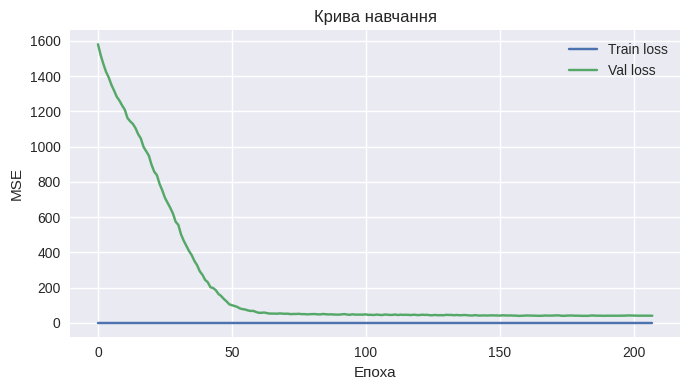

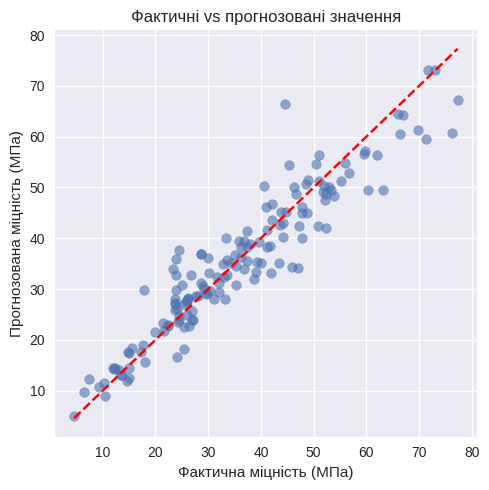

In [ ]:
plt.style.use("seaborn-v0_8")

plt.figure(figsize=(7, 4))
plt.plot(history["train"], label="Train loss")
plt.plot(history["val"],   label="Val loss")
plt.xlabel("Епоха")
plt.ylabel("MSE")
plt.title("Крива навчання")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y_test, preds, alpha=0.6)
lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("Фактична міцність (МПа)")
plt.ylabel("Прогнозована міцність (МПа)")
plt.title("Фактичні vs прогнозовані значення")
plt.tight_layout()
plt.show()


## Важливість ознак

                     feature  importance
0           CementComponent   233.224847
7                  AgeInDays  217.005264
1           BlastFurnaceSlag  115.003317
3             WaterComponent   68.300139
2            FlyAshComponent   40.338806
6     FineAggregateComponent   24.660606
5   CoarseAggregateComponent   19.602679
4  SuperplasticizerComponent   16.588924


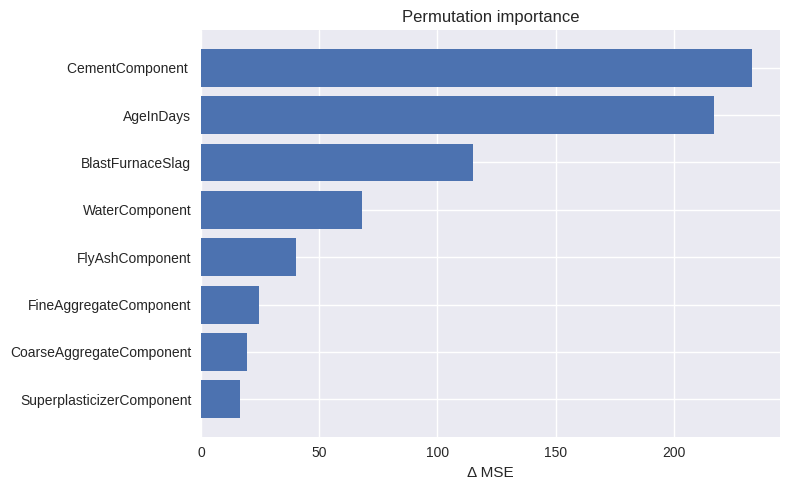

In [ ]:
def permutation_importance_nn(model, X_ref, y_ref, metric,
                              n_repeats=10, random_state=SEED):
    rng = np.random.default_rng(random_state)
    model.eval()
    with torch.no_grad():
        baseline = metric(
            y_ref,
            model(to_tensor(X_ref).to(device)).detach().cpu().numpy().ravel()
        )

    importances = np.zeros(X_ref.shape[1])

    for col in range(X_ref.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X_ref.copy()
            rng.shuffle(X_perm[:, col])
            with torch.no_grad():
                pred = model(to_tensor(X_perm).to(device)).detach().cpu().numpy().ravel()
            scores.append(metric(y_ref, pred) - baseline)
        importances[col] = np.mean(scores)

    return importances

importances = permutation_importance_nn(
    model, X_test, y_test.values,
    metric=mean_squared_error, n_repeats=20)

imp_df = (pd.DataFrame({"feature": X.columns,
                        "importance": importances})
          .sort_values("importance", ascending=False))

print(imp_df.head(10))

plt.figure(figsize=(8, 5))
plt.barh(imp_df.feature, imp_df.importance)
plt.gca().invert_yaxis()
plt.xlabel("Δ MSE")
plt.title("Permutation importance")
plt.tight_layout()
plt.show()


## Висновки
Під час аналізу даних були виявлені дублікати, аналіз кроскореляції ознак показав що взаємозалежність ознак в межах норми, тому було видалено дублікати, а кількість ознак була залишена без змін.
Перед побудовою моделі було застосовано налаштування повторюваності результатів моделі та підключено підтримку GPU (cuda).
При навчанні моделі було використоно метод ранньої зупинки навчання для уникнення перенавчання.
### Крива навчання
Стрімкий спад MSE протягом перших ≈ 60 епох (з ≈ 950 → ≈ 60) свідчить, що мережа швидко вивчила базові закономірності підготовки суміші.
Подальше «плато» (40 ± 1 МПа²) приводить до висновку, що після ~120 епох модель пібдирає дуже незначні відмінності ваг - відповідно приріст якості відбувається дуже повільно.
"Early Stopping" на 208‑ій епосі припинив навчання рівно тоді, коли валідна помилка почала зростати ─ отже, це дає надію, що перенавчання не допущено.
### Метрики
R² = 0.89 означає, що майже 90 % варіантів міцності можна пояснити наявними ознаками; 10 % може припадати на технологічні допуски та різними факторами присутніми на виробництві (температура твердіння, спосіб ущільнення, вологість повітря та тиск навколишнього середовища тощо).
MAE ≈ 3.8 МПа – це рівень похибки, який лежить в зоні похибок лабораторних випробувань, тому прогноз можна тестувати на практиці (наприклад, добір складу суміші або контроль якості).
### Важливість ознак
Найбільший вплив на MSE дає рандомізація водоцементного співвідношення (W/C) й цементу – отже, це основа міцності.
Менш критичними виявились шлакові та зольні добавки.
### Що можна було б покращити
- Додати/синтезувати нові ознаки: водоцементне W/C, вода + пластифікатор, S/D = великий/дрібний заповнювач, додати вік бетону, температуру твердінння (потрібна консультація із спеціалістами в цій сфері)
- Спробувати додати BatchNorm + Dropout (0.1‑0.2) між прихованими шарами або поексперементувати із шириною/глибиною мережі.
- Поексперементувати з K‑fold cross‑validation (k = 5) для більш стійкої оцінки чи Cyclical LR або CosineAnnealing
- Перевірити який результат може дати комбінація NN з Gradient Boosting (LightGBM/XGBoost)
